In [1]:
%run data_preparation.ipynb

Accessible dataframes    Description                            # of columns  
data_2019                Gives data for 2019-Baseline           15
data_2023                Gives data for 2023                    13
data_2024                Gives data for 2024                    13
station_data             Existing stations in NYC from Lyft      6


In [2]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

In [4]:
file_name = "C:/Users/lukas/OneDrive - Imperial College London/0_Data/Old_data/data_2020.pkl"
data_2020 = pd.read_pickle(file_name)

file_name = "C:/Users/lukas/OneDrive - Imperial College London/0_Data/Old_data/data_2021.pkl"
data_2021 = pd.read_pickle(file_name)

file_name = "C:/Users/lukas/OneDrive - Imperial College London/0_Data/Old_data/data_2022.pkl"
data_2022 = pd.read_pickle(file_name)

In [ ]:
# data_2023 = data_2023.drop(columns=['ride_id'])

In [66]:
data_2020

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,789,2020-01-01 00:00:55.390,2020-01-01 00:14:05.147,504,1 Ave & E 16 St,40.732219,-73.981656,307,Canal St & Rutgers St,40.714275,-73.989900,30326,Subscriber,1992,1
1,1541,2020-01-01 00:01:08.102,2020-01-01 00:26:49.178,3423,West Drive & Prospect Park West,40.661063,-73.979453,3300,Prospect Park West & 8 St,40.665147,-73.976376,17105,Customer,1969,1
2,1464,2020-01-01 00:01:42.140,2020-01-01 00:26:07.011,3687,E 33 St & 1 Ave,40.743227,-73.974498,259,South St & Whitehall St,40.701221,-74.012342,40177,Subscriber,1963,1
3,592,2020-01-01 00:01:45.561,2020-01-01 00:11:38.155,346,Bank St & Hudson St,40.736529,-74.006180,490,8 Ave & W 33 St,40.751551,-73.993934,27690,Subscriber,1980,1
4,702,2020-01-01 00:01:45.788,2020-01-01 00:13:28.240,372,Franklin Ave & Myrtle Ave,40.694546,-73.958014,3637,Fulton St & Waverly Ave,40.683239,-73.965996,32583,Subscriber,1982,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19506852,2045,2020-12-31 23:58:21.704,2021-01-01 00:32:27.157,526,E 33 St & 5 Ave,40.747659,-73.984907,3614,Crescent St & 30 Ave,40.768692,-73.924957,36467,Subscriber,1994,1
19506853,288,2020-12-31 23:58:37.840,2021-01-01 00:03:26.325,3307,West End Ave & W 94 St,40.794165,-73.974124,3383,Cathedral Pkwy & Broadway,40.804213,-73.966991,47749,Subscriber,1969,0
19506854,152,2020-12-31 23:58:52.809,2021-01-01 00:01:25.672,3510,Adam Clayton Powell Blvd & W 123 St,40.807832,-73.949373,3518,Lenox Ave & W 126 St,40.808442,-73.945209,48691,Customer,1969,0
19506855,654,2020-12-31 23:59:55.955,2021-01-01 00:10:50.605,4073,W 51 St & Rockefeller Plaza,40.759700,-73.978082,500,Broadway & W 51 St,40.762288,-73.983362,49564,Subscriber,1994,1


## Further Data Cleaning

In [7]:
data_2022['start_station_name']

0                     Boerum Pl\t& Pacific St
1                             E 12 St & Ave C
2                             W 21 St & 6 Ave
3                              38 St & 30 Ave
4                      Pacific St & Nevins St
                          ...                
30689916    E 41 St & Madison Ave (SW corner)
30689917                 Peck Slip & South St
30689918    E 41 St & Madison Ave (SW corner)
30689919                     W 37 St & 10 Ave
30689920                     W 37 St & 10 Ave
Name: start_station_name, Length: 30689921, dtype: category
Categories (1761, object): ['1 Ave & E 110 St', '1 Ave & E 16 St', '1 Ave & E 18 St', '1 Ave & E 30 St', ..., 'Wyckoff St & 3 Ave', 'Wyckoff St & Nevins St', 'Wythe Ave & Metropolitan Ave', 'Yankee Ferry Terminal']

In [15]:
bro_df = pd.DataFrame({'bro': pd.concat([data_2024['start_station_name'], data_2024['end_station_name']], ignore_index=True)})
len(bro_df['bro'].unique())

2169

In [71]:
len(data_2023)

36226600

In [61]:
data_2021

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,2513.0,2021-01-01 00:00:11.9020,2021-01-01 00:42:05.2260,3581.0,Underhill Ave & Lincoln Pl,40.674012,-73.967146,3581.0,Underhill Ave & Lincoln Pl,40.674012,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2519.0,2021-01-01 00:00:15.0960,2021-01-01 00:42:14.9780,3581.0,Underhill Ave & Lincoln Pl,40.674012,-73.967146,3581.0,Underhill Ave & Lincoln Pl,40.674012,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1207.0,2021-01-01 00:00:28.9300,2021-01-01 00:20:36.6510,3144.0,E 81 St & Park Ave,40.776777,-73.959010,3724.0,7 Ave & Central Park South,40.766741,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2506.0,2021-01-01 00:00:32.7130,2021-01-01 00:42:19.3980,3581.0,Underhill Ave & Lincoln Pl,40.674012,-73.967146,3581.0,Underhill Ave & Lincoln Pl,40.674012,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,959.0,2021-01-01 00:00:35.3650,2021-01-01 00:16:34.6010,534.0,Water - Whitehall Plaza,40.702551,-74.012723,332.0,Cherry St,40.712199,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27661446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-12-06 15:42:18,E 31 St & 3 Ave,6239.08,W 13 St & 5 Ave,5947.04,40.743943,-73.979661,40.735445,-73.994310,member
27661447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-12-12 13:58:42,MacDougal St & Washington Sq,5797.01,E 2 St & 2 Ave,5593.02,40.732264,-73.998522,40.725029,-73.990697,casual
27661448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-12-05 14:23:28,Schermerhorn St & Court St,4565.04,Warren St & Court St,4413.08,40.691029,-73.991834,40.686371,-73.993833,member
27661449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-12-31 11:57:19,Emerson Pl & Myrtle Ave,4683.02,4 Ave & 9 St,3955.05,40.693631,-73.962236,40.670513,-73.988766,member


In [ ]:
len(data_2021['start station name'].unique())
len(data_2023['start_station_name'].unique())

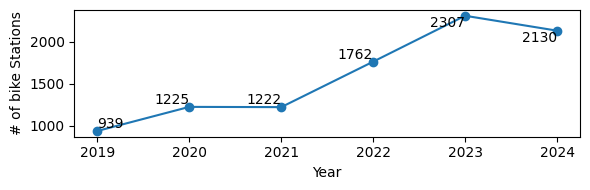

In [76]:
# Calculate the number of unique bike stations for each year
years = range(2019, 2025)
bike_stations = []

for year in years:
    # Determine the column name based on the year
    column_name = 'start station name' if year < 2022 else 'start_station_name'
    # Calculate the number of unique bike stations
    num_stations = len(globals()[f"data_{year}"][column_name].unique())
    bike_stations.append(num_stations)

# Plotting
plt.figure(figsize=(6., 2))
plt.plot(years, bike_stations, marker='o', linestyle='-')
# plt.title('Increase in Bike Stations Over Time')
plt.xlabel('Year')
plt.ylabel('# of bike Stations')
plt.grid(False)
plt.xticks(years)  # Set the x-axis ticks to be the years

# Display specific numbers

for i, txt in enumerate(bike_stations):
    if i==0:
        plt.text(years[i], bike_stations[i], str(txt), ha='left', va='bottom')
    elif 0<i<4:
        plt.text(years[i], bike_stations[i], str(txt), ha='right', va='bottom')
    elif i>=4:
        plt.text(years[i], bike_stations[i], str(txt), ha='right', va='top')

plt.tight_layout()
plt.show()

In [12]:
data_2019.dtypes

tripduration                      float64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                  float64
start station name               category
start station latitude            float64
start station longitude           float64
end station id                    float64
end station name                 category
end station latitude              float64
end station longitude             float64
bikeid                           category
usertype                         category
gender                           category
age                                 int64
dtype: object

In [13]:
# Print summary statistics
print(data_2019.describe())

# Check for any remaining missing values
print(data_2019.isnull().sum())

# Check for any remaining duplicates
print(data_2019.duplicated().sum())

       tripduration                      starttime  \
count  2.055170e+07                       20551697   
mean   8.613211e+02  2019-07-12 13:38:14.879607296   
min    6.100000e+01     2019-01-01 00:01:47.401000   
25%    3.620000e+02  2019-05-03 07:06:23.523000064   
50%    6.150000e+02  2019-07-18 11:44:48.559000064   
75%    1.079000e+03  2019-09-23 19:30:41.959000064   
max    3.263737e+04     2019-12-31 23:59:55.296000   
std    1.205452e+03                            NaN   

                            stoptime  start station id  \
count                       20551697      2.055152e+07   
mean   2019-07-12 13:54:33.631335680      1.663465e+03   
min       2019-01-01 00:07:07.581000      7.200000e+01   
25%       2019-05-03 07:18:43.400000      3.820000e+02   
50%    2019-07-18 11:59:51.628999936      5.140000e+02   
75%    2019-09-23 19:47:18.051000064      3.295000e+03   
max       2020-01-17 20:00:05.082000      3.911000e+03   
std                              NaN      1.47733

KeyboardInterrupt: 

In [59]:
columns_with_missing_values = data_2023.columns[data_2023.isna().any()].tolist()
print("Columns with missing values:")
print(columns_with_missing_values)

# Count the number of missing values in each column
na_count = data_2023.isna().sum()

# Print the number of missing values for each column
print("\nNumber of missing values in each column:")
print(na_count)


Columns with missing values:
['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'end_lat', 'end_lng']

Number of missing values in each column:
ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name     18688
start_station_id       18688
end_station_name      103267
end_station_id        103267
start_lat                  0
start_lng                  0
end_lat                26209
end_lng                26209
member_casual              0
dtype: int64


In [60]:
data_nan_location = data_2023[data_2023.isna().any(axis=1)]
data_nan_location

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
3545,2529A9FDE78680FD,classic_bike,2023-01-15 02:14:29,2023-01-15 03:18:05,Grand Concourse & E 167 St,8126.07,NaN,NaN,40.834159,-73.917773,40.830000,-73.910000,member
3547,398378C74A5B83B8,classic_bike,2023-01-04 11:26:22,2023-01-04 12:32:02,E 39 St & Lexington Ave,6389.09,NaN,NaN,40.749241,-73.976977,40.750000,-73.990000,member
3552,8A2AF59D4E40BF19,classic_bike,2023-01-22 10:02:33,2023-01-22 11:13:41,E 22 St & 2 Ave,5971.09,NaN,NaN,40.737092,-73.981020,40.720000,-74.000000,member
3554,35AF36FD3A9C200A,classic_bike,2023-01-01 22:33:59,2023-01-02 00:17:14,E 114 St & 1 Ave,7540.02,NaN,NaN,40.794560,-73.936191,40.800000,-73.940000,member
3555,E6DB61B72B773AB0,classic_bike,2023-01-16 13:13:24,2023-01-16 14:19:31,Wythe Ave & Metropolitan Ave,5348.02,NaN,NaN,40.717127,-73.963336,40.710000,-73.960000,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36217963,2A69554BFDEB9D84,classic_bike,2023-12-18 18:46:04,2023-12-18 18:48:53,NaN,NaN,W Broadway & Watts St,5569.07,40.730000,-74.000000,40.723230,-74.003140,member
36218120,2A38D1E708917754,classic_bike,2023-12-17 12:10:28,2023-12-17 12:35:00,NaN,NaN,W 76 St & Columbus Ave,7281.09,40.780000,-73.960000,40.780184,-73.977285,casual
36219741,EA6ABE945063F8F4,classic_bike,2023-12-06 11:50:00,2023-12-06 11:55:08,NaN,NaN,St Marks Pl & 2 Ave,5669.1,40.740000,-73.990000,40.728419,-73.987140,member
36224585,4D7435D7D9145753,classic_bike,2023-12-13 14:06:24,2023-12-13 14:30:25,NaN,NaN,E 1 St & Bowery,5636.13,40.760000,-73.970000,40.724861,-73.992131,member


In [ ]:
columns_with_missing_values = data_2019.columns[data_2019.isna().any()].tolist()
print("Columns with missing values:")
print(columns_with_missing_values)

# Count the number of missing values in each column
na_count = data_2019.isna().sum()

# Print the number of missing values for each column
print("\nNumber of missing values in each column:")
print(na_count)


Columns with missing values:
['start station id', 'start station name', 'end station id', 'end station name']

Number of missing values in each column:
tripduration                 0
starttime                    0
stoptime                     0
start station id           180
start station name         180
start station latitude       0
start station longitude      0
end station id             180
end station name           180
end station latitude         0
end station longitude        0
bikeid                       0
usertype                     0
birth year                   0
gender                       0
dtype: int64


In [ ]:
data_nan_location = data_2019[data_2019.isna().any(axis=1)]
data_nan_location

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
248483,2358,2019-01-08 13:48:13.812,2019-01-08 14:27:32.016,NaN,NaN,40.854,-73.890,NaN,NaN,40.857,-73.881,34550,Subscriber,1992,1
249690,3358,2019-01-08 14:29:31.515,2019-01-08 15:25:29.713,NaN,NaN,40.857,-73.884,NaN,NaN,40.857,-73.884,34550,Subscriber,1992,1
336359,596,2019-01-10 14:35:39.212,2019-01-10 14:45:35.413,NaN,NaN,40.863,-73.890,NaN,NaN,40.866,-73.884,34550,Subscriber,1986,1
337008,816,2019-01-10 14:56:38.425,2019-01-10 15:10:14.812,NaN,NaN,40.857,-73.890,NaN,NaN,40.854,-73.902,34447,Subscriber,1986,1
396461,393,2019-01-12 12:36:01.144,2019-01-12 12:42:34.952,NaN,NaN,40.854,-73.890,NaN,NaN,40.857,-73.884,34536,Customer,1997,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13292288,419,2019-08-28 04:56:24.076,2019-08-28 05:03:23.578,NaN,NaN,40.860,-73.899,NaN,NaN,40.860,-73.887,34428,Customer,1998,1
13292321,856,2019-08-28 05:05:22.354,2019-08-28 05:19:39.288,NaN,NaN,40.860,-73.887,NaN,NaN,40.848,-73.908,34428,Customer,1998,1
13292453,949,2019-08-28 05:23:29.688,2019-08-28 05:39:19.687,NaN,NaN,40.848,-73.908,NaN,NaN,40.854,-73.902,34428,Customer,1998,1
13293165,739,2019-08-28 06:09:32.525,2019-08-28 06:21:52.251,NaN,NaN,40.854,-73.899,NaN,NaN,40.848,-73.902,34428,Customer,1998,1


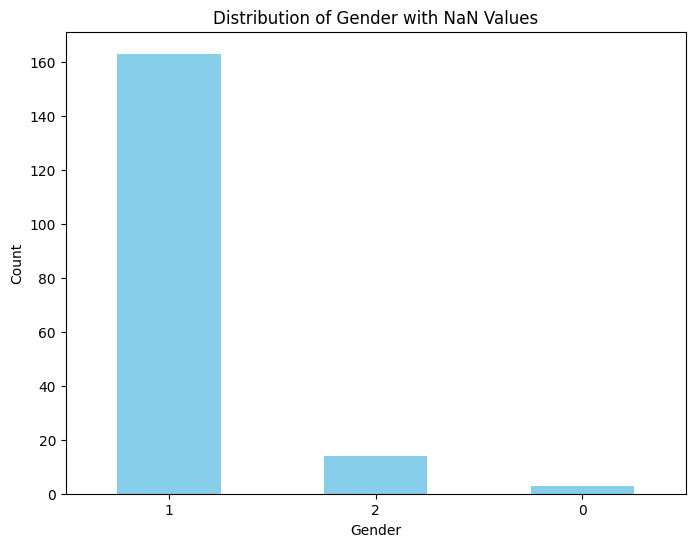

In [ ]:
plt.figure(figsize=(8, 6))
data_nan_location['gender'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Gender with NaN Values')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

In [ ]:
data_nan_location.describe()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,birth year
count,180.000000,180,180,0.0,180.000000,180.000000,0.0,180.000000,180.000000,180.000000
mean,1092.888889,2019-07-02 11:46:25.789355520,2019-07-02 12:04:39.151472384,NaN,40.857283,-73.893050,NaN,40.857100,-73.892983,1989.244444
min,80.000000,2019-01-08 13:48:13.812000,2019-01-08 14:27:32.016000,NaN,40.842000,-73.914000,NaN,40.842000,-73.914000,1969.000000
25%,403.250000,2019-07-25 16:19:02.836999936,2019-07-25 16:26:27.315749888,NaN,40.854000,-73.896750,NaN,40.854000,-73.896000,1984.500000
50%,693.000000,2019-07-31 18:03:04.578999808,2019-07-31 18:14:37.983500032,NaN,40.857000,-73.893000,NaN,40.857000,-73.893000,1992.000000
75%,1347.500000,2019-08-15 15:17:36.016250112,2019-08-15 15:32:10.785999872,NaN,40.863000,-73.890000,NaN,40.863000,-73.890000,1997.000000
max,10716.000000,2019-08-29 13:02:19.993000,2019-08-29 13:10:14.022000,NaN,40.869000,-73.878000,NaN,40.869000,-73.878000,2003.000000
std,1227.339084,NaN,NaN,NaN,0.006450,0.007193,NaN,0.006719,0.007331,9.093937


In [16]:
# Sort the DataFrame by the time column
data_2019.sort_values(by='starttime', inplace=True)

# Calculate the time differences between consecutive timestamps
time_diffs = data_2019['starttime'].diff().dt.total_seconds().dropna()

# Determine the most common or average time difference
average_interval = time_diffs.mean()
most_common_interval = time_diffs.mode()[0]

print("Average time interval:", average_interval, "seconds")
print("Most common time interval:", most_common_interval, "seconds")

Average time interval: 1.5344664447644574 seconds
Most common time interval: 0.001 seconds


In [ ]:
# Calculate the time differences between consecutive timestamps
time_diffs = data_2019['time_column'].diff().dt.total_seconds().dropna()

# Determine the most common or average time difference
average_interval = time_diffs.mean()
most_common_interval = time_diffs.mode()[0]

print("Average time interval:", average_interval, "seconds")
print("Most common time interval:", most_common_interval, "seconds")

In [ ]:
# Handle outliers
# Example: Clip tripduration to remove outliers
tripduration_mean = data_2019['tripduration'].mean()
tripduration_std = data_2019['tripduration'].std()
lower_bound = tripduration_mean - 3 * tripduration_std
upper_bound = tripduration_mean + 3 * tripduration_std
data_2019['tripduration'] = data_2019['tripduration'].clip(lower=lower_bound, upper=upper_bound)

# Convert birth year to age
current_year = pd.Timestamp.now().year
data_2019['age'] = current_year - data_2019['birth year']

# Remove rows with invalid ages (e.g., negative age)
data_2019 = data_2019[data_2019['age'] >= 0]

# Drop unnecessary columns
data_2019 = data_2019.drop(columns=['birth year'])

# Print summary statistics
print(data_2019.describe())

# Check for any remaining missing values
print(data_2019.isnull().sum())

# Check for any remaining duplicates
print(data_2019.duplicated().sum())

       tripduration                      starttime  \
count  2.055170e+07                       20551697   
mean   8.613211e+02  2019-07-12 13:38:14.879607296   
min    6.100000e+01     2019-01-01 00:01:47.401000   
25%    3.620000e+02  2019-05-03 07:06:23.523000064   
50%    6.150000e+02  2019-07-18 11:44:48.559000064   
75%    1.079000e+03  2019-09-23 19:30:41.959000064   
max    3.263737e+04     2019-12-31 23:59:55.296000   
std    1.205452e+03                            NaN   

                            stoptime  start station id  \
count                       20551697      2.055152e+07   
mean   2019-07-12 13:54:33.631335680      1.663465e+03   
min       2019-01-01 00:07:07.581000      7.200000e+01   
25%       2019-05-03 07:18:43.400000      3.820000e+02   
50%    2019-07-18 11:59:51.628999936      5.140000e+02   
75%    2019-09-23 19:47:18.051000064      3.295000e+03   
max       2020-01-17 20:00:05.082000      3.911000e+03   
std                              NaN      1.47733

# Colourful Map from 2019-2024

In [4]:
data_2019_t = data_2019.drop_duplicates(subset='start station name')
data_2020_t = data_2020.drop_duplicates(subset='start station name')
data_2021_t = data_2021.drop_duplicates(subset='start station name')
data_2022_t = data_2022.drop_duplicates(subset='start_station_name')
data_2023_t = data_2023.drop_duplicates(subset='start_station_name')
data_2024_t = data_2024.drop_duplicates(subset='start_station_name')

In [5]:
data_2019_t = data_2019_t.rename(columns={'start station latitude': 'start_lat', 'start station longitude': 'start_lng'})
data_2020_t = data_2020_t.rename(columns={'start station latitude': 'start_lat', 'start station longitude': 'start_lng'})
data_2021_t = data_2021_t.rename(columns={'start station latitude': 'start_lat', 'start station longitude': 'start_lng'})

In [6]:
data_2019_t = data_2019_t.dropna(subset=['start_lat'])
data_2020_t = data_2020_t.dropna(subset=['start_lat'])
data_2021_t = data_2021_t.dropna(subset=['start_lat'])
data_2022_t = data_2022_t.dropna(subset=['start_lat'])
data_2023_t = data_2023_t.dropna(subset=['start_lat'])
data_2024_t = data_2024_t.dropna(subset=['start_lat'])

data_2019_t = data_2019_t[['start_lat','start_lng']]
data_2020_t = data_2020_t[['start_lat','start_lng']]
data_2021_t = data_2021_t[['start_lat','start_lng']]
data_2022_t = data_2022_t[['start_lat','start_lng']]
data_2023_t = data_2023_t[['start_lat','start_lng']]
data_2024_t = data_2024_t[['start_lat','start_lng']]

In [28]:
station_dataframes = {
    2019: data_2019_t,
    2020: data_2020_t,
    # 2021: data_2021_t,
    2022: data_2022_t,
    2023: data_2023_t,
    2024: data_2024_t
}

In [35]:
# Create a map centered at a default location
map_center = [40.7, -73.9]  # Default center for New York City
m = folium.Map(location=map_center, zoom_start=11)

# Define colors for each year
colors = {2019: '#000004', 2020: '#57106e', 2022: '#bc3754', 2023: '#f98e09'} # ,2021: 'blueviolet'    ,2024: '#fcffa4'
# Add more colors for additional years if necessary

# Initialize a set to store unique station coordinates
unique_stations = set()
for year, df in sorted(station_dataframes.items()):
    # Calculate new stations for the current year compared to the previous year
    new_stations = set(zip(df['start_lat'], df['start_lng'])) - unique_stations
    
    # Iterate over new stations
    for lat, lon in new_stations:
        # Create a marker with a popup showing the year
        folium.CircleMarker(location=[lat, lon], radius=1, color=colors[year], fill=True, fill_color=colors[year],
                            fill_opacity=0.6, popup=f'Year: {year}').add_to(m)
        
        # Add new station coordinates to the set of unique stations
        unique_stations.add((lat, lon))

# Save the map to an HTML file
m.save('new_station_map_no_clustering_inc24.html')

In [ ]:
RGB(173, 216, 230) - Light Blue
RGB(135, 206, 235)
RGB(100, 149, 237)
RGB(65, 105, 225)
RGB(30, 144, 255) - Dodger Blue
RGB(0, 0, 139) - Dark Blue